<a href="https://colab.research.google.com/github/takumi19910112/google_colab/blob/main/binary_cross_entropy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
####################################
# Library
####################################
import warnings
warnings.simplefilter('ignore')

import os
import gc
gc.enable()
import sys
import glob
import math
import time
import random
import string
import psutil
import pathlib
import datetime
from pathlib import Path
from contextlib import contextmanager
from pprint import pprint
from types import SimpleNamespace

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from tqdm.auto import tqdm as tqdmp
from tqdm.autonotebook import tqdm as tqdm
tqdmp.pandas()

## Model
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
import tokenizers
import transformers
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")

tokenizers.__version__: 0.21.0
transformers.__version__: 4.48.3


In [ ]:
# binary_cross_entropyの実装のためのconfigを書く
# https://docs.python.org/ja/3.13/library/types.html#additional-utility-classes-and-functions

config = SimpleNamespace()

config.exp_name = '001-exp-binary'
config.exp_comment = 'baseline'
config.seed = 42
config.n_fold = 5
config.wandb = False

# MODEL
config.backbone = 'microsoft/deberta-v3-base'
config.fc_droprate = 0.3
config.max_len = 512
# binaryのため、2で設定
config.num_classes = 2

# TRAIN INFO
config.epochs = 3
config.train_loader = {
    "batch_size": 4,
    "shuffle": True,
    "num_workers": 0,
    "pin_memory": True,
    "drop_last": True,
}
config.valid_loader = {
    "batch_size": 4,
    "shuffle": False,
    "num_workers": 0,
    "pin_memory": True,
    "drop_last": False,
}
config.test_loader = {
    "batch_size": 4,
    "shuffle": False,
    "num_workers": 0,
    "pin_memory": True,
    "drop_last": False,
}
config.optimizer = {
    "name": "torch.optim.AdamW",
    "params": {
        "lr": 2e-5,
        "weight_decay": 0.01,
    },
}
# schedulerの設定
# schedulerっていうのは、学習率を動的に調整する仕組みのこと
# 学習の最初の方は大きめに設定しておいて、だんだん小さくして微調整するとか
# 新しい重み = 現在の重み - 学習率 × 勾配
config.scheduler = "cosine"
# Trueにすると、バッチごとにスケジューラーを更新する
# Falseにすると、エポックごとになる
# バッチ　→学習で使う、まとまった単位
config.batch_scheduler = True
config.cosine_num_cycles = 0.5
config.pct_wampup_steps = 0.15

config.apex = True
config.gradient_checkpointing = True
# 勾配クリッピングの設定（勾配爆発対策）
config.max_grad = 1000

pprint(config)

namespace(exp_name='001-exp-binary',
          exp_comment='baseline',
          seed=42,
          n_fold=5,
          wandb=False,
          backbone='microsoft/deberta-v3-base',
          fc_droprate=0.3,
          max_len=512,
          num_classes=2,
          epochs=3,
          train_loader={'batch_size': 4,
                        'drop_last': True,
                        'num_workers': 0,
                        'pin_memory': True,
                        'shuffle': True},
          valid_loader={'batch_size': 4,
                        'drop_last': False,
                        'num_workers': 0,
                        'pin_memory': True,
                        'shuffle': False},
          test_loader={'batch_size': 4,
                       'drop_last': False,
                       'num_workers': 0,
                       'pin_memory': True,
                       'shuffle': False},
          optimizer={'name': 'torch.optim.AdamW',
                     'params': {'lr': 2

In [ ]:
OUTPUT_DIR = Path(f'./{config.exp_name}')
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f'OUTPUT_DIR: {OUTPUT_DIR}')

OUTPUT_DIR: 001-exp-binary


In [ ]:
## 再現性確保のためのSeed固定
def seed_everything(seed:int==42):

    """pythonとosのseedを固定

    Args:
        seed (int, optional): 固定したいseed値. Defaults to =42.
    """

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.seed)

In [ ]:
## 処理にかかった時間と使用したメモリを計測
@contextmanager
def timer(name:str, slack:bool=False):

    """処理にかかった時間と使用したメモリを計測
    """

    t0 = time.time()
    p = psutil.Process(os.getpid())
    m0 = p.memory_info()[0] / 2. ** 30
    print(f'<< {name} >> Start')
    yield

    m1 = p.memory_info()[0] / 2. ** 30
    delta = m1 - m0
    sign = '+' if delta >= 0 else '-'
    delta = math.fabs(delta)

    print(f"<< {name} >> {m1:.1f}GB({sign}{delta:.1f}GB):{time.time() - t0:.1f}sec")

In [ ]:
'''
train.csvには、label1とlabe2がそれぞれ411件ずつ存在している。
なので、ランダムにシャッフルした後、1/3である137件ずつ抽出してそれをテスト用に、残りを学習用とした
'''

with timer('data load'):

    train_df = pd.read_csv("/content/drive/MyDrive/m_learn/train_label_0_1_only.csv")
    test_df = pd.read_csv("/content/drive/MyDrive/m_learn/test_label_0_1_only.csv")

    print(f'train: {train_df.shape}')
    print(f'test: {test_df.shape}')
    # print(train_df.head())
    print(test_df.head())

<< data load >> Start
train: (548, 3)
test: (274, 3)
                                              prompt  \
0  Write a short summary of the movie "The banshe...   
1  Summarize this job post:\n\nVEIL.AI is a Healt...   
2  Where do specialized kinetochore proteins atta...   
3  Can individuals who have recovered from COVID-...   
4  How this translates into priorities\n\nMuch of...   

                                                text  label  
0  Here is a dramatic 167-word summary of the mov...      1  
1  Here is a 200-word summary of the job post:\n\...      1  
2  Specialized kinetochore proteins attach to the...      1  
3  Yes, it is possible for individuals who have r...      1  
4  To summarize the key priorities outlined in th...      1  
<< data load >> 1.2GB(+0.0GB):0.9sec


In [ ]:
# dataframeの文章の長さなどを取得するために、先にtokenizerを準備
'''
tokenizer = テキストを単語とかで区切る＋その単語に一意のIDをふる
例
こんにちは、今日はいい天気ですね
→「こんにちは」、「、」、「今日は」、「いい」、「天気」、「ですね」
→それらの単語に一意なIDをふる
→08, 113, 503, 333, 290, 453, 22
'''
tokenizer = AutoTokenizer.from_pretrained(config.backbone)
config.tokenizer = tokenizer

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

In [ ]:
# https://colab.research.google.com/github/YutaroOgawa/pytorch_tutorials_jp/blob/main/notebook/0_Learn%20the%20Basics/0_2_data_tutorial_jp.ipynb#scrollTo=7wo_ipQkoH4v
'''
カスタムデータセットのクラス
カスタムデータセットクラスでは、__init__、__len__、__getitem__の3つは、絶対必要

__init__
・初期化関数
・コンストラクタ

__len__
・データセットのサンプル数を返す関数

__getitem__
・指定されたidxに対応するサンプルをデータセットから読み込んで返す関数（DojoDatasetでは第二引数に指定されている「item」が相当する）
・そのサンプルをテンソル型に変換している

'''

class DojoDataset:

    def __init__(self, config, df, train):

        self.config = config
        self.df = df
        self.train = train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, item):

        inputs = self.config.tokenizer.encode_plus(
            self.df.loc[item, 'text'],
            return_tensors=None,
            add_special_tokens=True,
            max_length=self.config.max_len,
            pad_to_max_length=True,
            truncation=True
        )

        for k, v in inputs.items():
            inputs[k] = torch.tensor(v, dtype=torch.long)

        if self.train:

            labels = self.df.loc[item, 'label']
            labels = torch.tensor(labels, dtype=torch.long)
            return inputs, labels

        else:
            return inputs

In [ ]:
print(torch.nn)

<module 'torch.nn' from '/usr/local/lib/python3.11/dist-packages/torch/nn/__init__.py'>


In [ ]:
'''
Poolingは、画像でいうところの、画像サイズを規則に従って縮小する処理のこと
プーリングウィンドウという、小さい領域を定義し、その領域内の代表値を抽出する
ストライド→プーリングウィンドウをずらしながら入力データをなぞること
MaxPoolingは、プーリングウィンドウ内の最大値を抽出する
MeanPooling(Avarage Poolingともいう)は、プーリングウィンドウ内の平均値を抽出する
forwardとは？
Poolingを、テキスト分類に使うとは？
def forwardは、順伝播を表しているらしい

・まず、前提として自然言語処理においては、トークナイザーによって各シーケンスをトークン単位に分割し、トークン別に一意のIDが振られている。
　・つまり自然言語をモデルが理解できる形（つまりテンソル型や行列など）にする
・次に、トークンは埋め込み（embedding）といわれる処理をされることによって、意味的に類似しているトークン同士の距離が近くなるような処理がされる
　・これがlast_hidden_stateにあたる（last_hidden_state＝シーケンスがembeddingされた状態）
・ただ、シーケンスごとに長さが異なると処理がしずらいので、パディングを入れるなりして固定長にする
・でも固定長にするとパディングが推論に影響してしまうので、アテンションマスクで無効化する
　・なのでシーケンスは固定長になりつつも、推論に影響がない状態になる
・で、ここからがプーリング。
　・各トークン（embeddingされたもの）は行列とかテンソルで表現されるので、それらを足す（ベクトルの足し算のイメージ）
　・で、これをトークン数でわる
　・そうすると、イメージ的にはベクトルの和を要素数で割ることになって、算術平均的な計算をしていることになる
　・これがMeanPooling
'''
# いわば、文章（シーケンス）ごとのベクトルを求めるということ
class MeanPooling(torch.nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

# いわば、文章中（シーケンス中）で最も大きなベクトルを求めている
class MaxPooling(nn.Module):
    def __init__(self):
        super(MaxPooling, self).__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = -1e4
        max_embeddings, _ = torch.max(embeddings, dim=1)
        return max_embeddings

'''
アテンションマスクを定義するメソッド
・シード値を42で固定する
・空のリストmaskを用意する
・for文でbatchの大きさ分だけ繰り返す
　・np.random.randint(1, seq, 1)[0]
　　・Numpy
　　・random.randint(x, y, z)
　　　・「x以上、y-1以下の整数のうち、ランダムにz個選ぶ」
　　　・これは配列で返す
　　・ので、[0]で最初の要素を取得
　　・まとめると、「1以上、(seq-1)以下の整数で、ランダムに1個選ぶ」
　・mask.append([1.] * l + [0.] * (seq - l))
　　・appendはリストに追加
　　　・[1.]は、「小数点がついた1」のこと
　　　　・これを、l回だけ繰り返す
　　　・[0.]は、「小数点がついた0」のこと
　　　　・これを、(seq-1)回だけ繰り返す
　・で、それをテンソル型にする
こんな感じ
print(gen_attention_mask(10, 10))
tensor([[1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.]])
'''
def gen_attention_mask(batch, seq):
    np.random.seed(42)
    mask = []
    for i in range(batch):
        l = np.random.randint(1, seq, 1)[0]
        mask.append([1.] * l + [0.] * (seq - l))
    return torch.as_tensor(mask)

tensor([[1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.]])


# 順伝播の図
- def forward
  - 順伝播のこと
  - 順伝播とは、Affine（全結合）層のあと活性化関数を使って次の隠れ層に進んで、さらにそれを繰り返して、、、のようないわゆる左から右に進んでいくこと
- シーケンス
  - シーケンス（sequence）とは、連続しているもの、一続きのもの、順序や順番を意味する言葉
  - テキスト分類においては、与えられた文章の長さを指しているっぽい
  - 長い文章を切り詰めて短い文章に合わせるか、短い文章にパディングという余白を入れて、長さを合わせるか
  - ただ、パディングを入れるということは本来関係ないものが入り込んでしまうので推論に影響がでることもある
- バッチ
  - まとまり
  - データセットをわけたグループのこと
  - バッチの中では同じシーケンスになってほしい


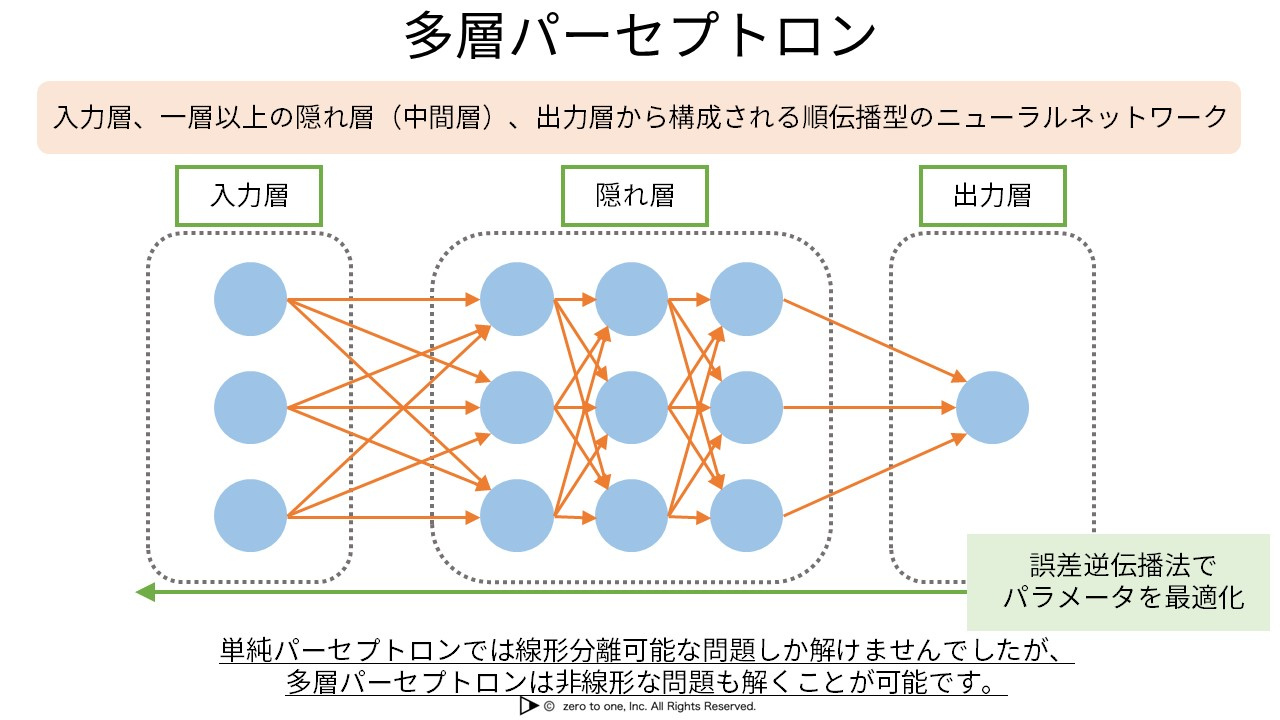

In [ ]:
'''
torchのnn.Moduleを継承して、カスタムモデル（自分で作成したモデル）を定義するクラス
__init__
・インタンス化した際に実行される
　・configから設定を読み込む
　・モデルが事前学習済みかどうかで条件分岐
　・プーリングは、平均プーリングとする
　・ドロップアウト（学習がうまくいかないときに意図的にニューロンからの情報をシャットアウトする）の設定
　　・今回は5つ
　・正則化の設定
　　・レイヤー正則化
'''

class CustomModel(nn.Module):

    def __init__(self, config, config_path, pretrained=False):

        super().__init__()
        self.config = config
        if config_path is None:
            self.model_config = AutoConfig.from_pretrained(self.config.backbone)
            self.model_config.update({"output_hidden_states": True})
            # 隠れ層におけるドロップアウト。ドロップアウトは、ニューロンのいくつかの経路を意図的に削除すること
            self.model_config.hidden_dropout = 0.
            self.model_config.hidden_dropout_prob = 0.
            self.model_config.attention_dropout = 0.
            self.model_config.attention_probs_dropout_prob = 0.
        else:
            self.model_config = torch.load(config_path)

        if pretrained:
            self.model = AutoModel.from_pretrained(self.config.backbone, config=self.model_config)
        else:
            self.model = AutoModel.from_config(self.model_config)
        # if self.config.gradient_checkpointing:
        #     self.model.gradient_checkpointing_enable()


        self.pool = MeanPooling()
        self.dropouts = nn.ModuleList([nn.Dropout(0.2) for _ in range(5)])
        self.norm = nn.LayerNorm(self.model_config.hidden_size)
        # fc = fully connected layerのこと。いわゆる、Affine（全結合）のこと
        self.fc = nn.Linear(self.model_config.hidden_size, self.config.num_classes)
        self._init_weights(self.fc)

    '''
    重みの初期値を設定する関数
    ニューラルネット
    '''
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.model_config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.model_config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

'''
特徴量を抽出するためのメソッド

'''
    def feature(self, inputs):
        # inputsはアンパックされたものなので、inputsという引数でいろいろ渡している
        outputs = self.model(
            **inputs
        )
        last_hidden_state = outputs.last_hidden_state
        attention_mask = inputs["attention_mask"]
        feature = self.pool(last_hidden_state, attention_mask)
        # feature = last_hidden_state[:, 0, :]
        return outputs, feature
'''
順伝播

'''
    def forward(self, inputs):
        _, feature = self.feature(inputs)

        # MultiSampleDropOut
        # outputs = sum([self.fc(dropout(feature)) for dropout in self.dropouts])/5
        outputs = self.fc(feature)

        return outputs

In [ ]:
# ====================================================
# Helper functions
# ====================================================
# 簡単に表現すると、学習した際のロスを計算するクラス
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train_func(config, train_loader, model, criterion, optimizer, scheduler, device, epoch):

    model.train()
    # Automatic Mixed Precision
    # 計算を効率的に行うやつ
    scaler = torch.cuda.amp.GradScaler(enabled=config.apex)
    # さっき定義したロス記録用の変数
    losses = AverageMeter()

    tq = tqdm(train_loader, total=len(train_loader))
    for step, (inputs, labels) in enumerate(tq):

        for k, v in inputs.items():
            # GPUで計算するためっぽい
            inputs[k] = v.to(device)

        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=config.apex):
            # モデルで予測する
            y_preds = model(inputs)
            # loss = criterion(y_preds.view(-1), labels.view(-1))
            # 誤差の計算
            # シグモイド関数を使っている→Binary Cross Entropy？
            loss = criterion(y_preds.sigmoid(), labels)

        # 損失の更新
        losses.update(loss.item(), batch_size)
        # 逆伝播
        scaler.scale(loss).backward()
        # 勾配クリッピング→勾配の上限値を設定して、勾配爆発を防ぐ
        # 勾配　→損失関数を偏微分したやつ（つまりどっちの方向に進むのかの指針てきな）
        grad_norm = torch.nn.utils.clip_grad_norm(model.parameters(), config.max_grad)

        scaler.step(optimizer)
        scaler.update()
        # 勾配のリセット
        optimizer.zero_grad()
        # 学習率設定
        scheduler.step()

        end = time.time()
        tq.set_description(f"Train Epoch: {epoch+1:2d} | Loss{losses.avg:.5f}")

    tq.close()
    _ = gc.collect()

    # そのエポック内の平均的な損失を返す
    return losses.avg

In [ ]:
def valid_func(valid_loader, model, criterion, device, epoch):

    losses = AverageMeter()
    model.eval()
    tq = tqdm(valid_loader, total=len(valid_loader))
    preds = []

    for step, (inputs, labels) in enumerate(tq):

        for k, v in inputs.items():
            inputs[k] = v.to(device)

        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            out = model(inputs)
            # loss = criterion(out.view(-1), labels.view(-1))
            loss = criterion(out.sigmoid(), labels)

        losses.update(loss.item(), batch_size)
        preds.append(out.sigmoid().detach().cpu().numpy())
        tq.set_description(f"Valid Epoch: {epoch+1:2d} | Loss{losses.avg:.5f}")

    tq.close()
    _ = gc.collect()
    valid_preds = np.concatenate(preds)

    return losses.avg, valid_preds

In [ ]:
def test_func(test_loader, model, device):

    model.eval()
    tq = tqdm(test_loader, total=len(test_loader))
    test_preds = []

    for step, inputs in enumerate(tq):

        for k, v in inputs.items():
            inputs[k] = v.to(device)

        with torch.no_grad():
            out = model(inputs)
            # loss = criterion(out.view(-1), labels.view(-1))

        test_preds.append(out.sigmoid().detach().cpu().numpy())

    tq.close()
    _ = gc.collect()
    test_preds = np.concatenate(test_preds)

    return test_preds

In [ ]:
##############################################
# Optimizer
##############################################
# オプティマイザーっていうのは最適化するのにつかうやつ

def get_optimizer_params(model, base_lr, weight_decay=0.0):

    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
            'lr': base_lr, 'weight_decay': weight_decay},
        {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
            'lr': base_lr, 'weight_decay': 0.0},
        {'params': [p for n, p in model.named_parameters() if "model" not in n],
            'lr': base_lr, 'weight_decay': 0.0}
    ]

    return optimizer_parameters

def get_scheduler(cfg, optimizer, num_train_steps):
    if config.scheduler=='linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=config.pct_wampup_steps,
            num_training_steps=num_train_steps
        )
    elif config.scheduler=='cosine':
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=config.pct_wampup_steps,
            num_training_steps=num_train_steps,
            num_cycles=config.cosine_num_cycles
        )
    return scheduler

In [ ]:
train_df['fold'] = -1
skf = StratifiedKFold(n_splits=config.n_fold, shuffle=True, random_state=config.seed)

for fold, (_, va_idx) in enumerate(skf.split(train_df, train_df['label'])):

    train_df.loc[va_idx, 'fold'] = fold+1

train_df['fold'] = train_df['fold'].astype('int')

pd.pivot_table(train_df, index='fold', columns='label', values='prompt', aggfunc='count')

In [ ]:
oof_prob = np.zeros((len(train_df), config.num_classes))

for fold in range(config.n_fold):

    print(f'★★★★★★★★★★★★★★★★ fold{fold+1} ★★★★★★★★★★★★★★★★')
    seed_everything(config.seed)
    device = 'cuda'

    X_train = train_df.query('fold != @fold + 1').reset_index(drop=True)
    X_valid = train_df.query('fold == @fold + 1').reset_index(drop=True)
    valid_idx = train_df.query('fold == @fold + 1').index.tolist()
    print(f'X_train: {len(X_train):,}, X_valid: {len(X_valid):,}')

    # この辺は、データセットとローダー
    train_dataset = DojoDataset(
        config,
        X_train,
        train=True
    )
    train_loader = DataLoader(
        train_dataset,
        **config.train_loader
    )

    valid_dataset = DojoDataset(
        config,
        X_valid,
        train=True
    )
    valid_loader = DataLoader(
        valid_dataset,
        **config.valid_loader
    )

    ########################## Model #########################
    # 上で定義したカスタムモデルの呼び出し
    model = CustomModel(config, config_path=None, pretrained=True)
    torch.save(model.model_config, f'{OUTPUT_DIR}/config.pth')
    model.to(device)

    ########################## Optimizer #########################
    optimizer_parameters = get_optimizer_params(
        model,
        base_lr=config.optimizer["params"]["lr"],
        weight_decay=0.01
    )
    optimizer = AdamW(
        optimizer_parameters,
        lr=config.optimizer["params"]["lr"],
        eps=1e-6,
        betas=(0.9, 0.999)
    )

    ########################## Scheduler #########################
    num_train_steps = int(len(X_train) / config.train_loader['batch_size'] * config.epochs)
    scheduler = get_scheduler(config, optimizer, num_train_steps)

    ########################## Loop #########################
    # criterion = nn.BCEWithLogitsLoss(reduction='mean')
    criterion = nn.CrossEntropyLoss(reduction='mean')
    best_score = 0
    best_val_pred = None
    best_model_file_name = f"{OUTPUT_DIR}/{config.exp_name}_fold{fold}.pth"


    for epoch in range(config.epochs):

        train_loss = train_func(
            config,
            train_loader,
            model,
            criterion,
            optimizer,
            scheduler,
            device,
            epoch
        )

        valid_loss, valid_pred = valid_func(valid_loader, model, criterion, device, epoch)

        valid_score = f1_score(
            X_valid['label'],
            np.argmax(valid_pred, axis=1),
            average='macro'
        )

        print(f"Epoch: {epoch+1:2d} | train_loss:{train_loss:.4f} | valid_loss:{valid_loss:.4f} | valid_score:{valid_score:.4f} |")

        if valid_score > best_score:
            best_score = valid_score
            best_val_pred = valid_pred
            print(f"Epoch {epoch+1} - Saving the best model with score {best_score:.4f}")
            torch.save({"model": model.state_dict(), "predictions": valid_pred}, best_model_file_name)

    oof_prob[valid_idx] += best_val_pred